<a href="https://colab.research.google.com/github/CreamNuts/cifar10/blob/master/Cifar_pytorch(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch
import torchvision
from tqdm import tqdm
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import random
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [4]:
batch_size = 128
total_epoch = 100
total_time = 0
avg_cost = 0

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


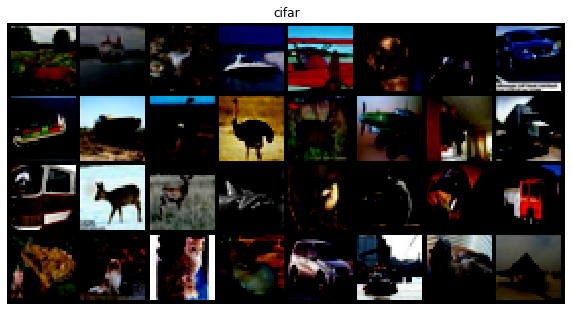

In [5]:
def imshow(img):
  npimg = img.numpy()
  plt.figure(figsize=(10,10))
  plt.title('cifar')
  plt.axis('off')
  timg=np.transpose(npimg ,(1,2,0))
  plt.imshow(timg)

images,labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images[:32]))
plt.show()

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #first layer
    #img shape = (batch, 3(input), 32, 32)
    #Conv = (batch, 32(output), 32, 32)
    #Pool = (batch, 32(output), 16, 16)
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    #second layer
    #img shape = (batch, 32(input), 16, 16)
    #Conv = (batch, 64(output), 16, 16)
    #Pool = (batch, 64(output), 8, 8)
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    #fc layer
    #8*8*64(input) -> 10class(output)
    self.fc = nn.Linear(8*8*64, 10, bias = True)
    
    #fc layer weigth initialize
    nn.init.xavier_uniform_(self.fc.weight)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) # flatten
    out = self.fc(out)
    return out

In [0]:
model = CNN().to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
total_batch = len(trainloader)
print(f'total_batch : {total_batch}')

total_batch : 390


In [11]:
train_acc_list = []
test_acc_list = []

for epoch in tqdm(range(total_epoch)):
  train_acc = 0
  test_acc = 0
  for X,y in trainloader:
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    hypothesis = model(X)
    cost = criterion(hypothesis, y)
    cost.backward()
    optimizer.step()
    with torch.no_grad():
      train_acc += (hypothesis.argmax(1)==y).float().mean()
  train_acc_list.append(train_acc/total_batch)
  for X,y in testloader:
    with torch.no_grad():
      X = X.to(device)
      y = y.to(device)
      test_result = model(X)
      test_acc += (test_result.argmax(1)==y).float().mean()
  test_acc_list.append(test_acc/len(testloader))

100%|██████████| 100/100 [18:28<00:00, 11.33s/it]


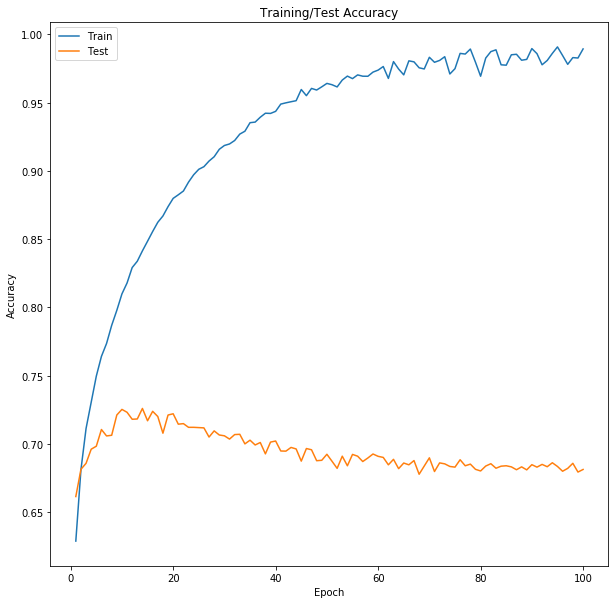

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_acc_list)+1), train_acc_list)
ax.plot(range(1, len(test_acc_list)+1), test_acc_list)
ax.legend(['Train', 'Test'])
plt.show()